In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.layers import Input, Dense, Flatten, Lambda, Reshape
from keras.models import Model
from keras.optimizers import Adam
from keras.losses import mse

tf.random.set_seed(1)

In [38]:
(train_img,_),(test_img,_)=tf.keras.datasets.mnist.load_data()

height,width=28,28

train_img=train_img.reshape(train_img.shape[0],height,width,1).astype('float32')
train_img/=255
train_img[train_img>=0.5]=1
train_img[train_img<=0.5]=0

test_img=test_img.reshape(test_img.shape[0],height,width,1).astype('float32')
test_img/=255
test_img[test_img>=0.5]=1
test_img[test_img<=0.5]=0

train_buffer=60000
test_buffer=10000

batch_size=100
latent_dimensions=2

train_set=tf.data.Dataset.from_tensor_slices(train_img).shuffle(train_buffer).batch(batch_size)
test_set=tf.data.Dataset.from_tensor_slices(test_img).shuffle(test_buffer).batch(batch_size)

In [39]:
def encoder(x):
    x=Conv2D(32,3,activation='relu',padding='same',strides=2)(x)
    x=Conv2D(64,3,activation='relu',padding='same',strides=2)(x)
    #x=MaxPooling2D()(x)
    return x

In [40]:
def decoder(x):
    #x=UpSampling2D()(x)
    x=Conv2DTranspose(64,3,activation='relu',padding='same',strides=2)(x)
    x=Conv2DTranspose(32,3,activation='relu',padding='same',strides=2)(x)
    return x

In [41]:
def sampling(args):
    z_mean,z_log_sigma=args
    epsilon=tf.random.normal(shape=tf.shape(z_mean))
    z=z_mean+tf.exp(0.5*z_log_sigma)*epsilon
    return z

In [42]:
inputs=Input(shape=(height,width,1))

encoded=encoder(inputs)
shape=encoded.get_shape()[1:]
encoded=Flatten()(encoded)

z_mean=Dense(latent_dimensions)(encoded)
z_log_sigma=Dense(latent_dimensions)(encoded)
z=Lambda(sampling)([z_mean,z_log_sigma])

input_embed=Input(shape=latent_dimensions)
embed=Dense(np.prod(shape),activation='relu')(input_embed)
embed=Reshape(shape)(embed)

decoded=decoder(embed)
output=Conv2DTranspose(1,3,padding='same')(decoded)

In [43]:
encode=Model(inputs,z)
encode.summary()

decode=Model(input_embed,output)
decode.summary()

Model: "functional_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 14, 14, 32)   320         input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 7, 7, 64)     18496       conv2d_6[0][0]                   
__________________________________________________________________________________________________
flatten_3 (Flatten)             (None, 3136)         0           conv2d_7[0][0]                   
______________________________________________________________________________________

In [44]:
reconstruction=decode(encode(inputs))
vae=Model(inputs,reconstruction)
vae.summary()

Model: "functional_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
functional_19 (Functional)   (None, 2)                 31364     
_________________________________________________________________
functional_21 (Functional)   (None, 28, 28, 1)         65089     
Total params: 96,453
Trainable params: 96,453
Non-trainable params: 0
_________________________________________________________________


In [45]:
mse_loss=tf.reduce_mean(mse(inputs,reconstruction)*height*width)
vae.add_loss(mse_loss)
vae.add_metric(mse_loss,'mse_loss')

kl_loss=tf.reduce_mean(-0.5*(1+z_log_sigma-tf.square(z_mean)-tf.exp(z_log_sigma)))*0.01
vae.add_loss(kl_loss)
vae.add_metric(kl_loss,'kl_loss')

vae.compile(optimizer=Adam())

In [46]:
history=vae.fit(train_set,verbose=1,epochs=5,batch_size=batch_size,validation_data=test_set)

Epoch 1/5
600/600 [==============================] - 30s 51ms/step - loss: 58.7648 - mse_loss: 58.7146 - kl_loss: 0.0502 - val_loss: 55.7806 - val_mse_loss: 55.7399 - val_kl_loss: 0.0407
Epoch 2/5
600/600 [==============================] - 32s 53ms/step - loss: 52.1739 - mse_loss: 52.1226 - kl_loss: 0.0513 - val_loss: 51.0902 - val_mse_loss: 51.0388 - val_kl_loss: 0.0514
Epoch 3/5
600/600 [==============================] - 30s 51ms/step - loss: 50.1243 - mse_loss: 50.0708 - kl_loss: 0.0535 - val_loss: 49.4293 - val_mse_loss: 49.3747 - val_kl_loss: 0.0546
Epoch 4/5
600/600 [==============================] - 31s 51ms/step - loss: 48.9713 - mse_loss: 48.9158 - kl_loss: 0.0555 - val_loss: 48.8184 - val_mse_loss: 48.7617 - val_kl_loss: 0.0567
Epoch 5/5
600/600 [==============================] - 31s 52ms/step - loss: 48.2749 - mse_loss: 48.2189 - kl_loss: 0.0560 - val_loss: 48.5621 - val_mse_loss: 48.5051 - val_kl_loss: 0.0570


In [115]:
def showimg(img, ax, title=None, vmin=0, vmax=1):
    ax.imshow(img.squeeze(), vmin=vmin, vmax=vmax)
    ax.set_title(title)
    ax.axis('off')

def summary_plot(n,inputs,d):
    idx = np.random.choice(len(inputs), size=n, replace=False)
    input_img = inputs[idx]
    z = encode.predict(input_img)
    output_img = decode.predict(z)
    if d==0:
        diff = output_img - input_img
    fig, ax = plt.subplots(3-d, n, figsize=((3)*n,10))
    for i in range(n):
        encoding = ', '.join(f'{zi:.2f}' for zi in z[i][:3]) + ', ...'
        showimg(input_img[i], ax[0, i], f'input {idx[i]}')
        showimg(output_img[i], ax[1, i], f'output\n{encoding}')
        if d==0:
            showimg(diff[i], ax[2, i], 'output-input', vmin=-0.5, vmax=0.5)

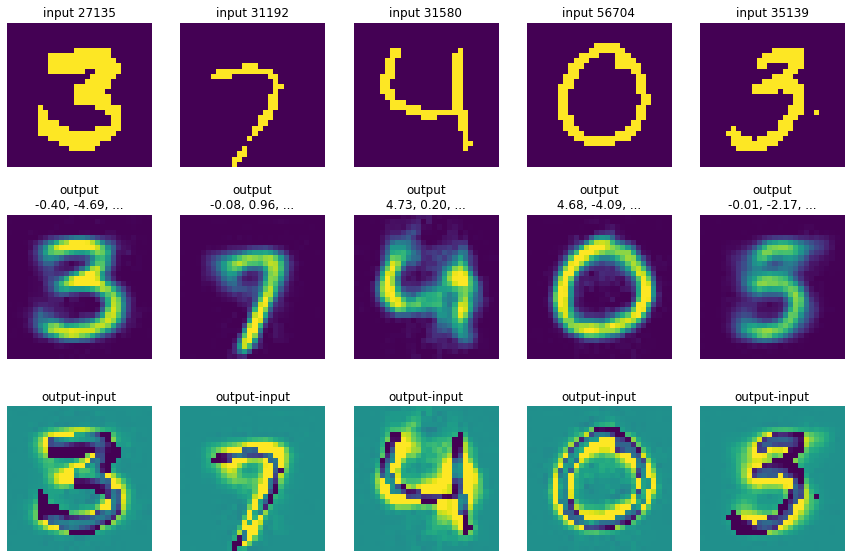

In [116]:
n=5
summary_plot(n,train_img,0)

In [117]:
from keras.preprocessing.image import ImageDataGenerator

datagen=ImageDataGenerator(rotation_range=360,width_shift_range=0.25,height_shift_range=0.25,
                             shear_range=20.0,zoom_range=[1.5, 2])

gen=datagen.flow(train_img, None, 1)

num=5
comps=2
components=np.array([[gen.next()[0, ..., 0] for j in range(comps)] for i in range(num)])
blended=components.sum(axis=1)

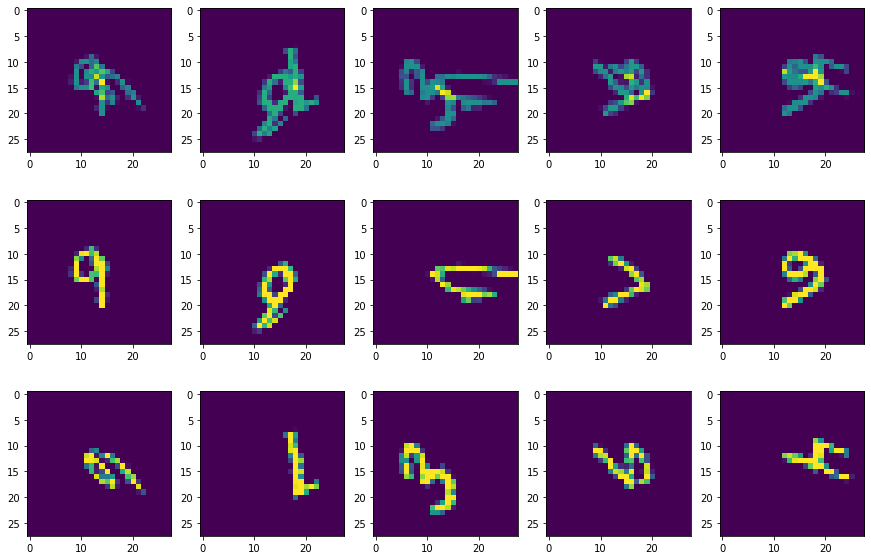

In [118]:
fig,ax=plt.subplots(3,num,figsize=(3*num, 10))
for i in range(num):
    ax[0,i].imshow(blended[i],interpolation='nearest')
    for j in range(comps):
        ax[j+1,i].imshow(components[i, j],interpolation='nearest')  

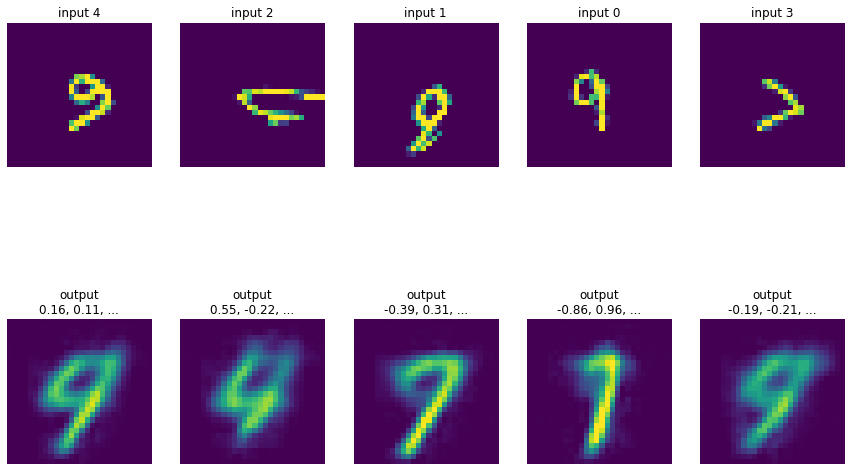

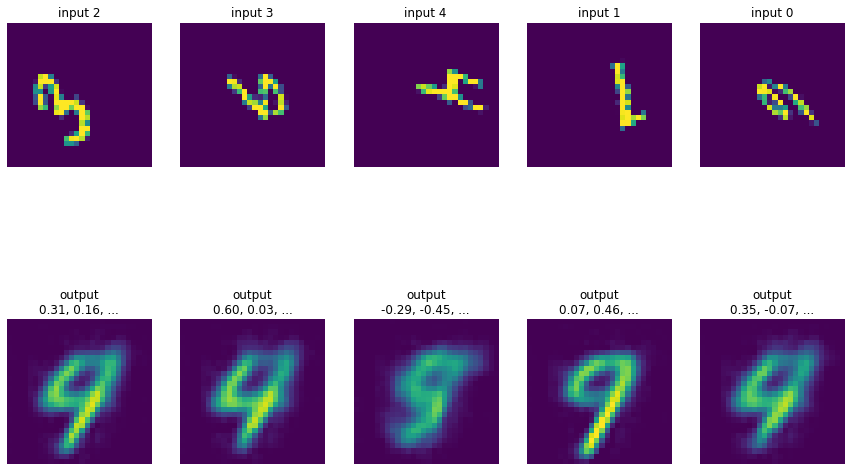

In [119]:
summary_plot(num,components[:,0],1)
summary_plot(num,components[:,1],1)

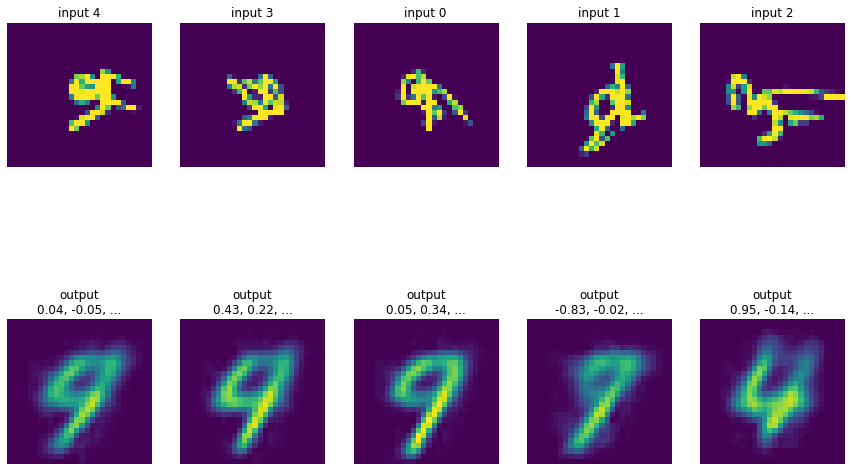

In [120]:
summary_plot(num,blended,1)